## Bonus - SST Forecasting Using SARIMA

In this bonus notebook, we demonstrate basic forecasting capabilities using CoralTemp SST data. This would potentially replace the forecasting method used in our previous analysis.

### Setup 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import datetime

# New packages
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm
from pylab import rcParams

### Load Data

In [5]:
# Create empty dataframe
sst_df = pd.DataFrame()

# Append all data into single dataframe
for f in glob.glob("data/*.csv"):
    df = pd.read_csv(f,
                     usecols = [0,3],
                     names = ["date", "sst_c"], 
                     skiprows = 2)
    sst_df = sst_df.append(df, ignore_index = True)

# Change date column from str to datetime and make it the index
sst_df['date'] = pd.to_datetime(sst_df['date'])
sst_df = sst_df.set_index(['date'])

sst_df.head()

,sst_c
date,
1985-11-09 12:00:00+00:00,25.45
1985-11-10 12:00:00+00:00,25.56
1985-11-11 12:00:00+00:00,25.70
1985-11-12 12:00:00+00:00,25.87
1985-11-13 12:00:00+00:00,26.02


We also need to resample our data to be monthly means rather than daily readings in order to make the forecasting approach more intuitive and straightforward. Due to the seasonality of SST data, it is much easier to forecast monthly data rather than daily.

<AxesSubplot:xlabel='date'>

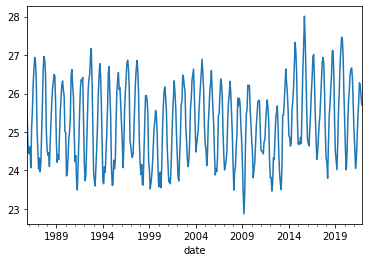

In [6]:
# SST data resampled to monthly means to make forecasting more approachable
sst_month_avg = sst_df['sst_c'].resample('MS').mean()

sst_month_avg.plot()

### Visualize Trends

The decomposition plot shows the primary components of our time-series data. We can see the overall, seasonal, and residual trends. It is evident that seasonal variation is the primary driver of SST change over time.

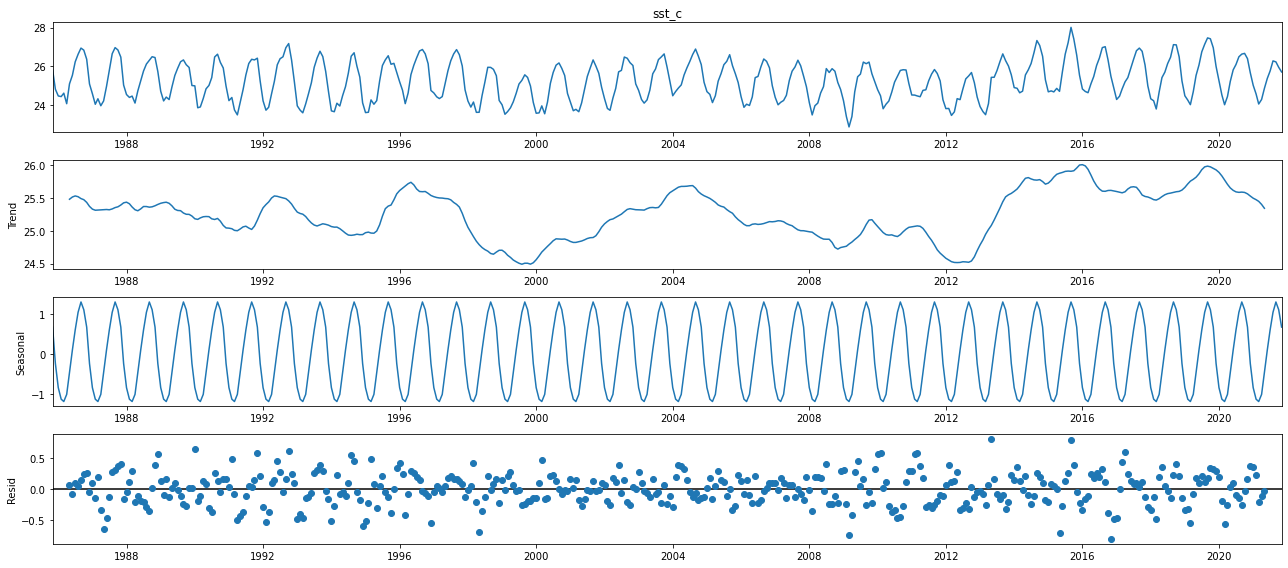

In [7]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sst_month_avg, model='additive')
fig = decomposition.plot()
plt.show()

Next, we show the autocorrelation of our time-series data. This plot again demonstrates the clear seasonal trend that we are observing. Data with a lag of 12 months have a high positive correlation with present data and data with a lag of 6 months have a high negative correlation. This is due to consistent seasonal temperature fluctuations.

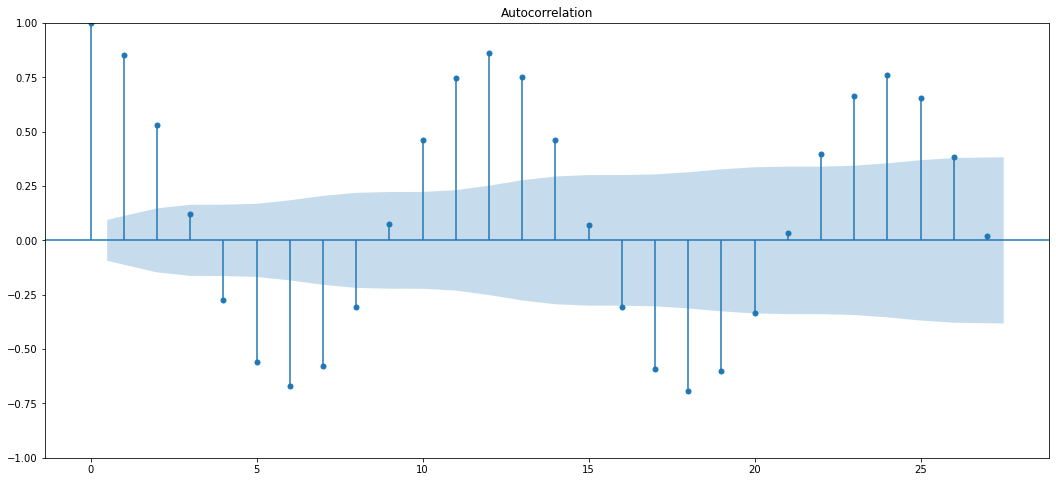

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sst_month_avg)
plt.show()

### SARIMA - Method 1

There are numerous forecasting methods and selecting the most "accurate" method is often the primary question that a research study aims to address. Due to limited time, we only test and implement a **Seasonal Auto-Regressive Integrated Moving Average** (SARIMA) model. We chose this model because it is highly popular for modeling time-series data with a seasonality component.

The following code chunk demonstrates the importance of selecting the parameters for our SARIMA model, which is a complex task requiring significant knowledge of the model and data. Below, we show a sample of parameter choices and their corresponding Akaike information criterion (AIC), which is an estimator of model prediction error (thus, theoretically the lower the AIC, the better the model).

In [9]:
warnings.filterwarnings("ignore")

p = range(0, 2)
d = range(0, 1) # Limited range to display quicker
q = range(0, 1) # Limited range to display quicker
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sst_month_avg,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4018.463250442299
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:598.4304714093298
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.3682601730756
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:284.53862378112944


Out of our sample parameter choices below, we would select the fourth option because we observe the lowest AIC. The model results are then displayed below.

In [10]:
mod = sm.tsa.statespace.SARIMAX(sst_month_avg,
                                order=(1,0,0),
                                seasonal_order=(1,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7275      0.033     22.012      0.000       0.663       0.792
ar.S.L12       0.9982      0.002    409.866      0.000       0.993       1.003
sigma2         0.1136      0.007     16.452      0.000       0.100       0.127


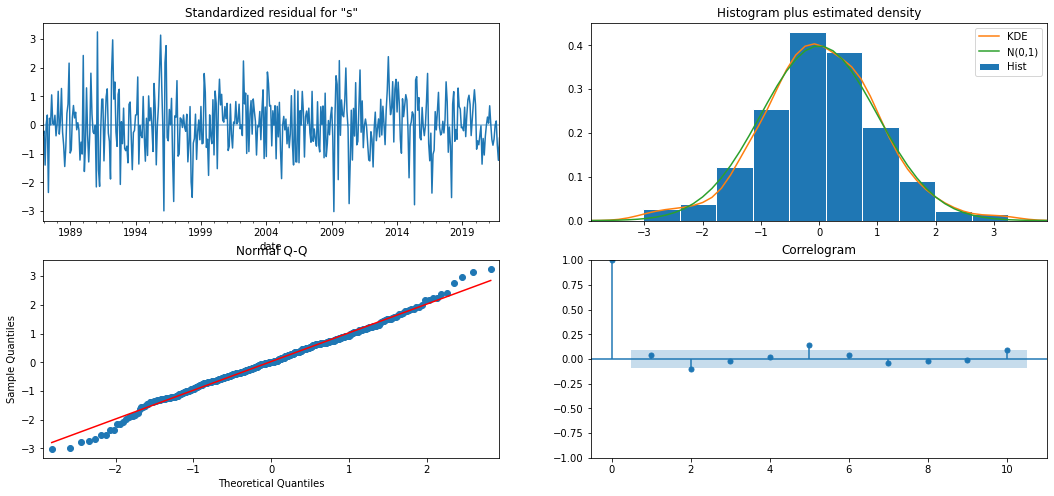

In [11]:
results.plot_diagnostics(figsize=(18,8))
plt.show()

Next, we can use these model results to forecast values. The plot below demonstrates predicted and observed SST from 2015 to present.

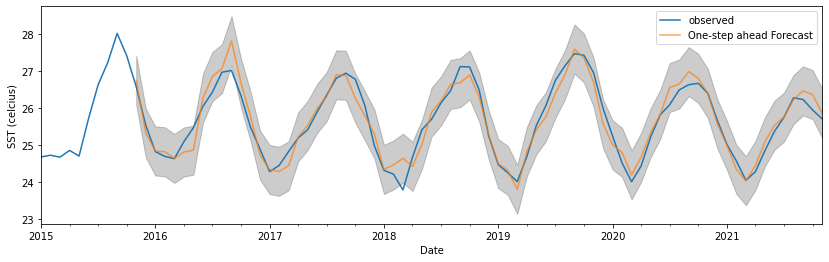

In [12]:
start = '2015-11-01 00:00:00+00:00'

pred = results.get_prediction(start=pd.to_datetime(start), dynamic=False)

pred_ci = pred.conf_int()

ax = sst_month_avg['2015':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SST (celcius)')
plt.legend()
plt.show()

The mean squared error and root mean squared error can be used to determine the accuracy of predictions.

In [13]:
y_forecasted = pred.predicted_mean
y_truth = sst_month_avg[start:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.07
The Root Mean Squared Error is 0.27


Lastly, we forecast future values.

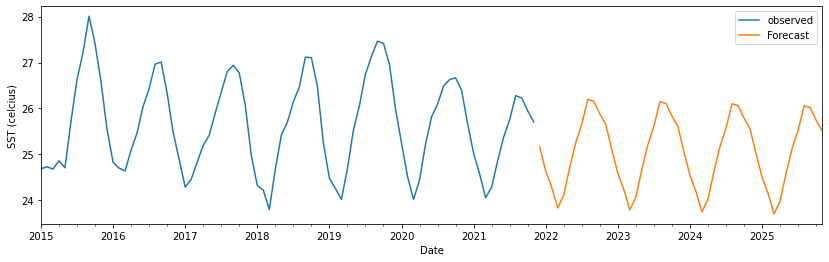

In [14]:
pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = sst_month_avg['2015':].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('SST (celcius)')
plt.legend()
plt.show()

### SARIMA - Method 2

Another method for creating a SARIMA model is to use `auto_arima`, which automates the selection of parameters. In the code chunk below, we split our dataset into two parts akin to "training" and "validation" datasets common in more rigorous machine learning techniques.

In [15]:
split = len(sst_month_avg[sst_month_avg.index.year < 2017])
dataset, validation = sst_month_avg[:split], sst_month_avg[split:]
print('Dataset length: %d, Validation length: %d' % (len(dataset), len(validation)))

Dataset length: 374, Validation length: 59


<AxesSubplot:xlabel='date'>

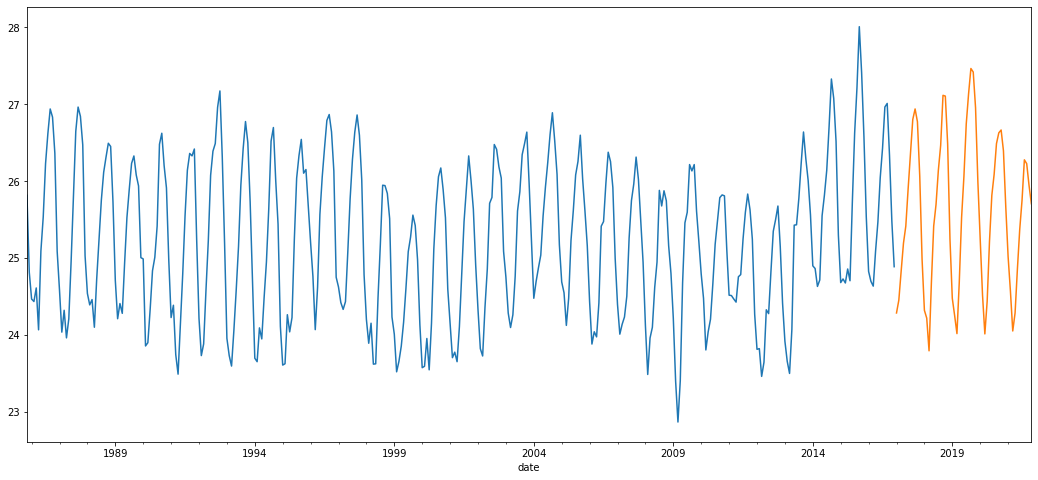

In [16]:
dataset.plot()
validation.plot()

With `trace = True`, we see that `auto_arima` performs a similar operation as before. We can similarly display the results of our model.

In [17]:
model = pm.auto_arima(dataset, m = 12, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(dataset)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=282.290, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1054.487, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=252.822, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=514.584, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3477.600, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=583.290, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=198.386, Time=0.72 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=406.759, Time=0.33 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=246.997, Time=1.46 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=208.725, Time=1.71 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=352.821, Time=0.78 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=556.602, Time=0.67 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : 

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [18]:
auto_results = model.fit(dataset)
print(auto_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8966      0.296      3.031      0.002       0.317       1.476
ar.L1          0.6810      0.047     14.470      0.000       0.589       0.773
ma.L1          0.2129      0.056      3.834      0.000       0.104       0.322
ar.S.L12       0.8885      0.031     28.397      0.000       0.827       0.950
ma.S.L12      -0.4588      0.072     -6.353      0.000      -0.600      -0.317
sigma2         0.0903      0.007     13.707      0.000       0.077       0.103


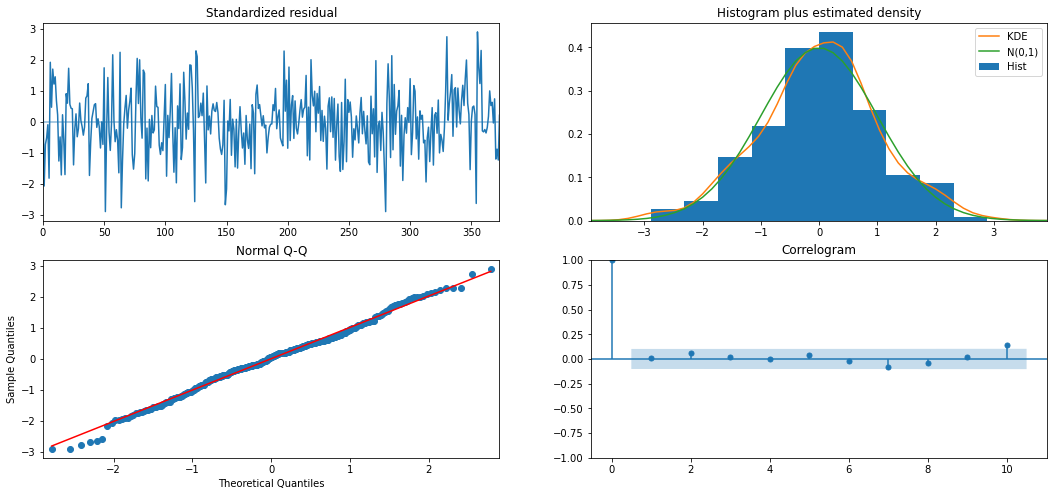

In [19]:
auto_results.plot_diagnostics(figsize=(18,8))
plt.show()

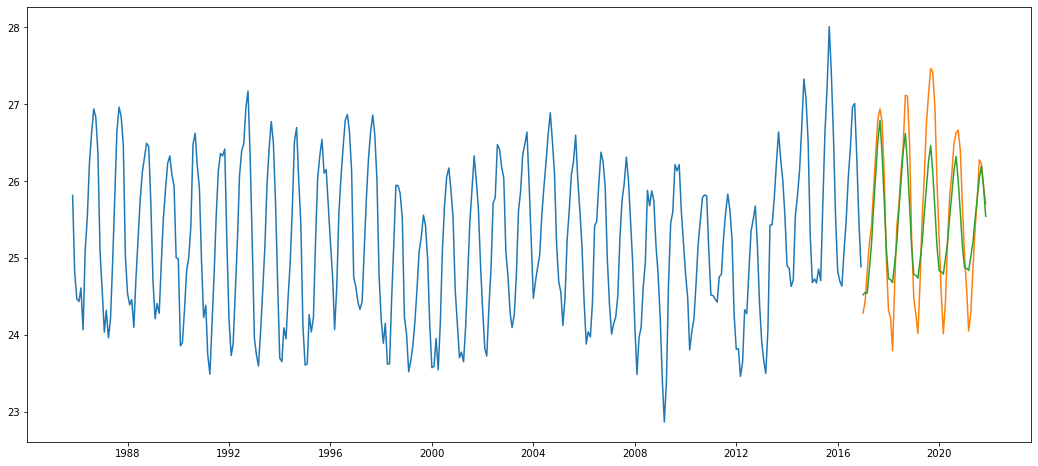

In [20]:
forecast = model.predict(n_periods = len(validation))
forecast = pd.DataFrame(forecast, index = validation.index, columns = ['Prediction'])
                        
plt.plot(dataset)
plt.plot(validation)
plt.plot(forecast)
plt.show()

### Conclusion

Further mastery in time-series forecasting combined with domain expertise in Sea Surface Temperature datasets is needed to accurately integrate a forecasting model such as `SARIMA` into our analysis. However, the techniques as shown above are approachable even for fledgling data scientists such as ourselves.